In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import langid
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTENC

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics  import accuracy_score
from sklearn.metrics import  confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

In [5]:
df1=pd.read_csv('Final_Dataset.csv')
df2=pd.read_csv('arstechnica_data.csv')
df3=pd.read_csv('Conversation_data.csv')

In [6]:
frames = [df1, df2, df3]
df = pd.concat(frames, ignore_index=True)

In [7]:
df.shape

(3131, 3)

In [8]:
df.head()

,article,titre,categorie
0,Enlarge / A composite of three DALL-E 3 AI art...,From toy to tool: DALL-E 3 is a wake-up call f...,biz & it
1,Enlarge\nGetty Images\n55\nWITH\nOne of the wo...,Ransomware group reports victim it breached to...,biz & it
2,Enlarge / McLaren Automotive got its start wit...,"With each iteration, this supercar gets better...",cars
3,Enlarge / UnitedHealthcare (UHC) health insura...,UnitedHealth uses AI model with 90% error rate...,Null
4,"Enlarge / A shot of tldraw's ""Make it Real"" in...",“Make It Real” AI prototype wows devs by turni...,biz & it


In [9]:
df.tail()

,article,titre,categorie
3126,À l’heure où le tourisme est un phénomène mond...,Les effets pervers du classement au patrimoine...,arts + culture
3127,"Tout comme les humains, les animaux doivent ac...",Ce que le sommeil des éléphants nous apprend s...,home page
3128,Traversant six siècles d’histoire (de 1420 à n...,« Les imaginaires sexuels coloniaux ont façonn...,home page
3129,Tandis que le cancer et d’autres maladies non-...,Des plantes appréciées des chimpanzés pourraie...,home page
3130,La population du continent africain s’accroît ...,"En 2100, plus d’un Terrien sur trois africain ?",home page


Le dataframe contient des articles en Francais et anglais. <b> On va procéder à la suppression des articles en Français. </b>

### Extraction des articles en anglais

In [10]:
def detect_language(sentence):
    lang, _ = langid.classify(sentence)
    return lang

In [11]:
def clean_dataframe(df):
    # Apply language detection to the title
    df['language'] = df['titre'].apply(detect_language)

    # Keep only rows where the language is not French ('fr')
    cleaned_df = df[df['language'] != 'fr'].copy()

    # Drop the 'language' column as it was temporary
    cleaned_df.drop(columns=['language'], inplace=True)

    return cleaned_df

In [12]:
df=clean_dataframe(df)

In [13]:
df.shape

(2999, 3)

### Nettoyage du dataframe

In [14]:
# Clean the 'categorie' column: remove leading and trailing whitespaces + lower
df['categorie'] = df['categorie'].str.strip().str.lower()

In [15]:
df.isnull().sum()

article      0
titre        0
categorie    0
dtype: int64

In [16]:
df.categorie.value_counts()

categorie
null                    607
biz & it                446
science                 314
policy                  313
cars                    285
tech                    277
gaming & culture        143
environment + energy    116
science + tech          112
politics                 89
education                88
arts + culture           76
health + medicine        69
business + economy       57
home page                 7
Name: count, dtype: int64

In [17]:
#drop Nulls
df=df.drop(df[df['categorie']=='null'].index,axis=0)

In [18]:
#drop home page
df=df.drop(df[df['categorie']=='home page'].index,axis=0)

In [19]:
df.shape

(2385, 3)

In [20]:
df.categorie.value_counts()

categorie
biz & it                446
science                 314
policy                  313
cars                    285
tech                    277
gaming & culture        143
environment + energy    116
science + tech          112
politics                 89
education                88
arts + culture           76
health + medicine        69
business + economy       57
Name: count, dtype: int64

-> Notre dataset contient 2385 articles scrapés

### Nettoyage de la colonne categorie

In [40]:
def category_cleaning(s):
    s = str(s)
    s = s.lower()
    s = s.replace(" & "," + ")
    s = s.replace('biz', 'business')
    s = s.replace('policy', 'politics')
    if s=='science':
        s = s.replace('science', 'science + tech')
    if s=='tech':
        s = s.replace('tech', 'science + tech')
    if ( s=='gaming + culture' ):
        s = s.replace('gaming + culture', 'arts + culture')
    if s=='business + it':
        s = s.replace('business + it', 'business')
    if s=='business + economy':
        s = s.replace('business + economy', 'business')
    return s

In [41]:
df['categorie'] = df['categorie'].apply(category_cleaning)

In [42]:
df

,article,titre,categorie
0,composite three dall ai art generations oil pa...,toy tool dall wake call visual artists rest us,business
1,getty images one world active ransomware group...,ransomware group reports victim breached sec r...,business
2,mclaren automotive got start clinical mp evolu...,iteration supercar gets better mclaren tested,cars
4,shot tldraw make real action provided ashe ok ...,make real ai prototype wows devs turning drawi...,business
6,sonos notes arc soundbar pairs dolby atmos upw...,sonos finally fixed dolby atmos pop death arc ...,science + tech
...,...,...,...
3076,weather forecasting important science accurate...,science weather forecasting takes hard get right,science + tech
3077,nigeria south africa bi national commission la...,case nigeria south africa cooperate outer spac...,science + tech
3078,curious kids series children ask experts answe...,curious kids would happen mosquitoes world dis...,science + tech
3079,rooibos tea uniquely south african product pla...,zebrafish research reveals green rooibos tea a...,science + tech


### Nettoyage de la colonne titre

In [27]:
stop_words=set(stopwords.words('english'))

In [28]:
def title_cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s) #whitespace followed by a non-word character removal
    s = re.sub('\W,\s',' ',s) #on-word character followed by a comma and whitespace removal
    s = re.sub(r'[^\w\s]', ' ', s) #punctuation removal
    s = re.sub('\d+', '', s) #digits removal
    s= re.sub(r'\b\w\b', '', s) #single letters removal
    s = s.strip()
    s = re.sub('\s+',' ',s) #multiple consecutive whitespaces removal
    #remove stopwords
    words = word_tokenize(s)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

In [29]:
df['titre'] = df['titre'].apply(title_cleaning)

In [32]:
df.loc[0]['titre']

'toy tool dall wake call visual artists rest us'

### Nettoyage de la colonne article

In [30]:
def article_cleaning(s):
    s = str(s)
    s = s.lower()
    s = s.replace("enlarge","")
    s = re.sub('\s\W',' ',s) #whitespace followed by a non-word character removal
    s = re.sub('\W,\s',' ',s) #on-word character followed by a comma and whitespace removal
    s = re.sub(r'[^\w\s]', ' ', s) #punctuation removal
    s = re.sub("\d+", "", s) #digits removal
    s = re.sub(r'http\S+','',s) #urls removal
    s= re.sub(r'\b\w\b', '', s) #single letters removal
    s = s.strip()

    s = re.sub('\s+',' ',s) #multiple consecutive whitespaces removal
     
    #Ortographic cleaning
    #s=TextBlob(s)
    #s=str(s.correct())

    #remove stopwords
    words = word_tokenize(s)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

In [31]:
df['article'] = df['article'].apply(article_cleaning)

In [33]:
df.loc[0]['article']

'composite three dall ai art generations oil painting hercules fighting shark photo queen universe marketing photo marshmallow menace cereal dall benj edwards october openai launched newest ai image generator dall wide release chatgpt subscribers dall pull media generation tasks would seemed absurd two years ago although inspire delight unexpectedly detailed creations also brings trepidation science fiction forecast tech like long ago seeing machines upend creative order feels different actually happening eyes reading openai new ai image generator pushes limits detail prompt fidelity impossible dismiss power ai comes image generation says aurich lawson ars technica creative director rapid increase visual acuity ability get usable result question beyond gimmick toy legit tool advent ai image synthesis looking increasingly like future media creation many come aid creative machines replicate artistic style format medium media reality becoming completely fluid malleable ai image synthesis 

In [34]:
#wordcloud
wordcloud = WordCloud(width=800, height=400, 
                      random_state=21, 
                      max_font_size=110,
                      #max_words=70,
                      collocations=False, #collocations = False is used to use single words instead of bi-grams (pairs of words) (the default)
                      colormap='RdYlGn',
                      background_color='white').generate(df.loc[0]['article']) 

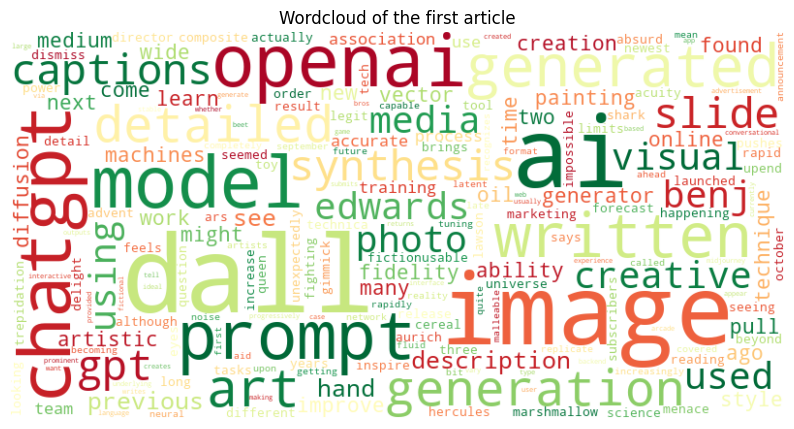

In [35]:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud of the first article')
plt.axis('off')
plt.show()

#### Distribution des categories d'articles

In [43]:
df['categorie'].value_counts()

categorie
science + tech          703
business                503
politics                402
cars                    285
arts + culture          219
environment + energy    116
education                88
health + medicine        69
Name: count, dtype: int64

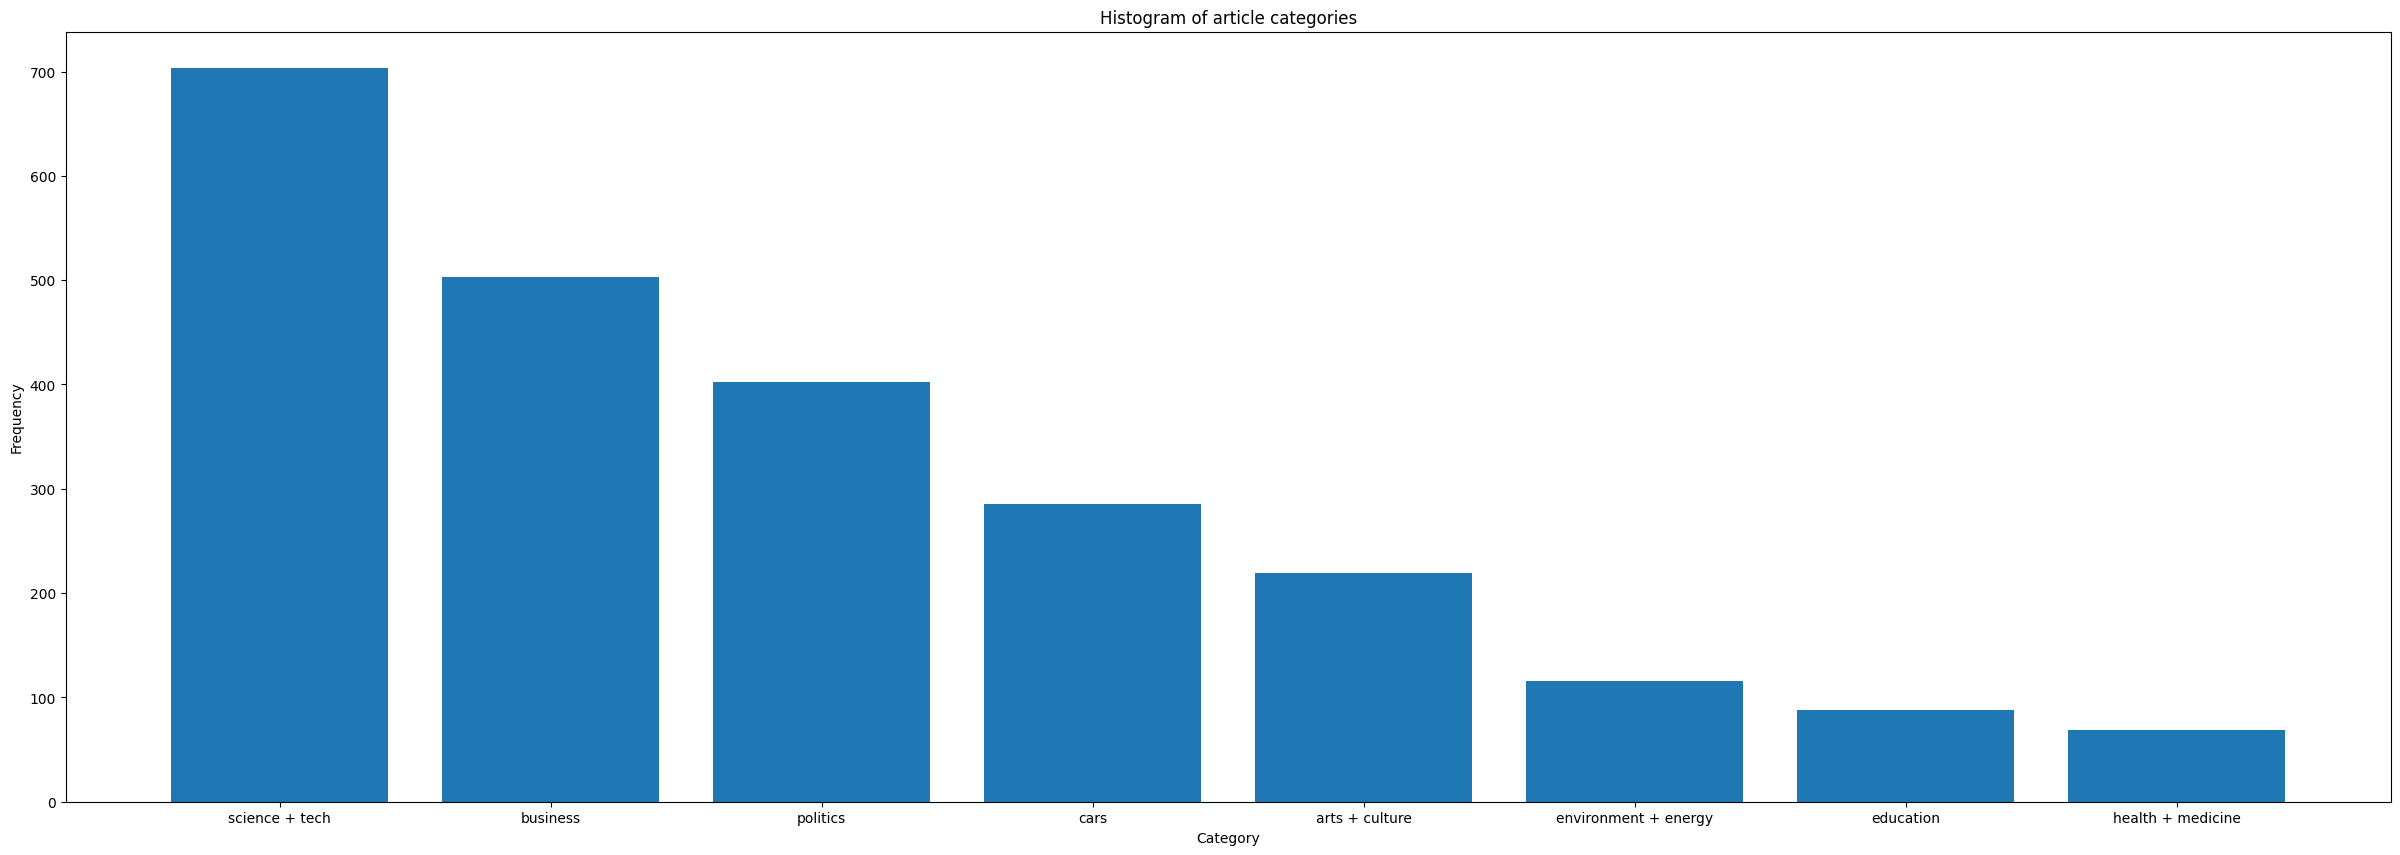

In [44]:
category_value_counts = df['categorie'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(30, 10))
plt.bar(category_value_counts.index, df['categorie'].value_counts())
plt.title('Histogram of article categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

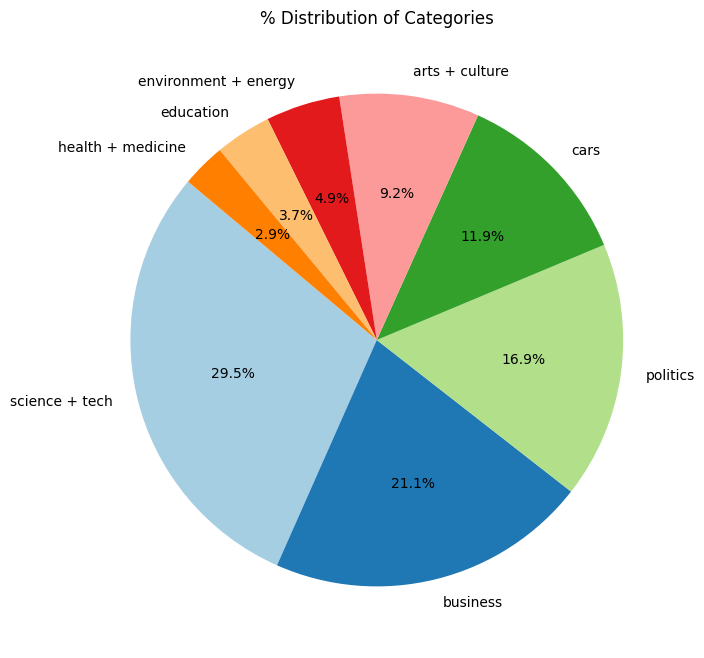

In [45]:
plt.figure(figsize=(8,8))
plt.pie(category_value_counts, labels=category_value_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Paired') )
plt.title('% Distribution of Categories')
plt.show()

Le dataset a l'air d'être desequilibré. On procédera a un overfitting avec la méthode SMOTE. 

# Data preprocessing :
## 1- Tokenization : 
Separating text into tokens 
## 2- Lemmatization :
Converting a word to its base form, removing grammatical inflection.
## 3- Stemming :
Reducing a word to its word stem

## Tokenization

In [54]:
def tokenization(text):
    lst=text.split()
    return lst

In [55]:
df.article=df.article.apply(tokenization)

In [56]:
df.head()

,article,titre,categorie
0,"[composite, three, dall, ai, art, generations,...",toy tool dall wake call visual artists rest us,business
1,"[getty, images, one, world, active, ransomware...",ransomware group reports victim breached sec r...,business
2,"[mclaren, automotive, got, start, clinical, mp...",iteration supercar gets better mclaren tested,cars
4,"[shot, tldraw, make, real, action, provided, a...",make real ai prototype wows devs turning drawi...,business
6,"[sonos, notes, arc, soundbar, pairs, dolby, at...",sonos finally fixed dolby atmos pop death arc ...,science + tech


## Lemmatization :

In [57]:
lemmatizer=nltk.stem.WordNetLemmatizer()

In [58]:
def lemmatize(liste):
    return([lemmatizer.lemmatize(i) for i in liste])

In [59]:
df.article=df.article.apply(lemmatize)

In [60]:
df.article[0]

['composite',
 'three',
 'dall',
 'ai',
 'art',
 'generation',
 'oil',
 'painting',
 'hercules',
 'fighting',
 'shark',
 'photo',
 'queen',
 'universe',
 'marketing',
 'photo',
 'marshmallow',
 'menace',
 'cereal',
 'dall',
 'benj',
 'edward',
 'october',
 'openai',
 'launched',
 'newest',
 'ai',
 'image',
 'generator',
 'dall',
 'wide',
 'release',
 'chatgpt',
 'subscriber',
 'dall',
 'pull',
 'medium',
 'generation',
 'task',
 'would',
 'seemed',
 'absurd',
 'two',
 'year',
 'ago',
 'although',
 'inspire',
 'delight',
 'unexpectedly',
 'detailed',
 'creation',
 'also',
 'brings',
 'trepidation',
 'science',
 'fiction',
 'forecast',
 'tech',
 'like',
 'long',
 'ago',
 'seeing',
 'machine',
 'upend',
 'creative',
 'order',
 'feel',
 'different',
 'actually',
 'happening',
 'eye',
 'reading',
 'openai',
 'new',
 'ai',
 'image',
 'generator',
 'push',
 'limit',
 'detail',
 'prompt',
 'fidelity',
 'impossible',
 'dismiss',
 'power',
 'ai',
 'come',
 'image',
 'generation',
 'say',
 'auric

In [61]:
 #original form of article (text)
df.article=df.article.apply(lambda x: "".join(i+" " for i in x))

In [62]:
df.head()

,article,titre,categorie
0,composite three dall ai art generation oil pai...,toy tool dall wake call visual artists rest us,business
1,getty image one world active ransomware group ...,ransomware group reports victim breached sec r...,business
2,mclaren automotive got start clinical mp evolu...,iteration supercar gets better mclaren tested,cars
4,shot tldraw make real action provided ashe ok ...,make real ai prototype wows devs turning drawi...,business
6,sonos note arc soundbar pair dolby atmos upwar...,sonos finally fixed dolby atmos pop death arc ...,science + tech


## Feature extraction :
Converting raw text data into a format that can be easily processed by machine learning algorithms.

Many techniques exists : 
CountVectorizer, TF-IDF, word embeddings, bag of words, bag of n-grams ...

TF-IDF is used in this exemple 


TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that reflects the importance of a word in a document or corpus

In [63]:
vectorizer=TfidfVectorizer(min_df=6)  
x=vectorizer.fit_transform(df.article)

In [64]:
y=df.categorie

In [65]:
print("Number of features extracted")
print(len(vectorizer.get_feature_names_out()))
print(vectorizer.get_feature_names_out()[:20])

Number of features extracted
8187
['ababa' 'abandon' 'abandoned' 'abdel' 'ability' 'able' 'aboard' 'abraham'
 'abrams' 'abroad' 'abrupt' 'abruptly' 'absence' 'absent' 'absolutely'
 'absorb' 'absorbed' 'absorbing' 'abstract' 'absurd']


## Models training
### 1- Preprocessing

In [66]:
#transforming categorie into numerical using label encoder

In [67]:
le=LabelEncoder()
y=le.fit_transform(y)

In [68]:
#train test split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=1)

In [75]:
# Apply SMOTE only to the training data
sm = SMOTE(random_state=42)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

In [76]:
models=["decision tree ","random forest","LGBM","Multinominal NB","SGDC"]
scores=[]

In [77]:
def eval(y,y_pred):
    #print("Accuracy of the model")
    #print(accuracy_score(y,y_pred))
    print("Accuracy of the model:", round(accuracy_score(y,y_pred)*100,2),"%")
    scores.append(round(accuracy_score(y,y_pred),2))

## Decision Tree

In [78]:
dt=DecisionTreeClassifier()
dt.fit(x_train_sm,y_train_sm)
y_pred=dt.predict(x_test)
eval(y_test,y_pred)

Accuracy of the model: 94.34 %


<Axes: >

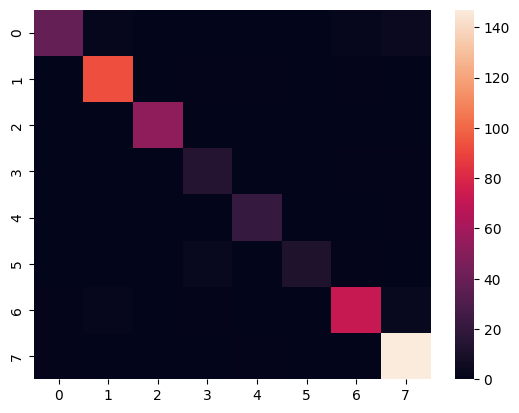

In [79]:
conf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix)

## Random Forest Classifier 

In [80]:
rf=RandomForestClassifier()
rf.fit(x_train_sm,y_train_sm)
y_pred=rf.predict(x_test)
eval(y_test,y_pred)

Accuracy of the model: 95.39 %


<Axes: >

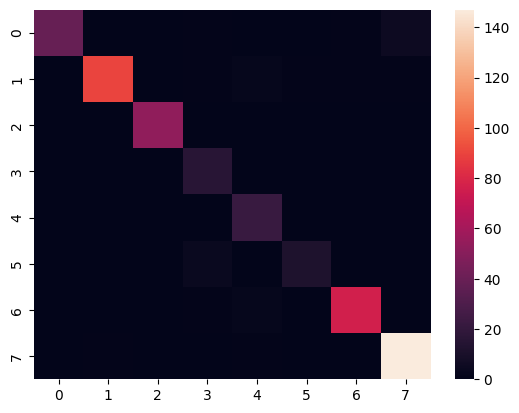

In [81]:
conf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix)

## LGBM

In [82]:
lgbm=LGBMClassifier()
lgbm.fit(x_train_sm,y_train_sm)
y_pred=lgbm.predict(x_test)
eval(y_test,y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 301253
[LightGBM] [Info] Number of data points in the train set: 4432, number of used features: 7720
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

## Multinominal NB

In [83]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train_sm,y_train_sm)
y_pred=mnb.predict(x_test)
eval(y_test,y_pred)

Accuracy of the model: 90.15 %


## SGDC

In [84]:
SGD=SGDClassifier()
SGD.fit(x_train_sm,y_train_sm)
y_pred=SGD.predict(x_test)
eval(y_test,y_pred)

Accuracy of the model: 96.44 %


<Axes: >

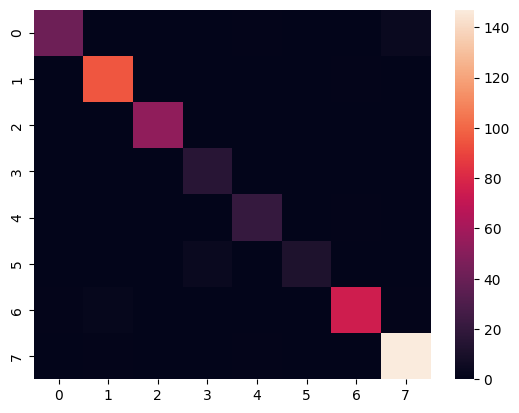

In [86]:
conf_matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix)

## Parameter tunning 

In [87]:
#define a grid function to determine best parameters for each model 
def grid_funct (model,param_grid,X_train,Y_train):
        grid=GridSearchCV(model,param_grid,cv=5)
        grid.fit(X_train,Y_train)
        print("score: ",grid.best_score_)
        print("estimatore: ",grid.best_estimator_)
        print("Parameters: ",grid.best_params_)
        scores.append(grid.best_score_)
        models.append(grid.best_estimator_)

[Text(0, 0, '0.94'),
 Text(0, 0, '0.95'),
 Text(0, 0, '0.96'),
 Text(0, 0, '0.9'),
 Text(0, 0, '0.96')]

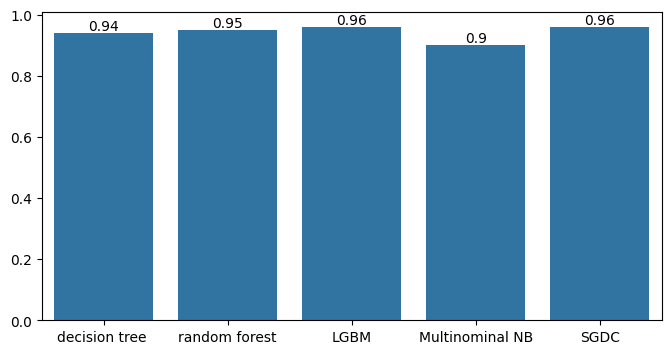

In [88]:
plt.figure(figsize=(8,4))
ax = sns.barplot( x=models, y=scores)
ax.bar_label((ax.containers[0]), fontsize=10)

-> The best model is the SGDC